# Welcome and have fun learning

#### Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. In this lesson, we'll learn how to create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other. 

Objective of this notebook used to be a ~simple~ and robust time series regression for future use.

<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

**Notes:**

## Imports and Configuration ##

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns


import ipywidgets as widgets
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import gc
import os
import math
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


# Fine tuning

In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
PRODUCTION = False # True: For submission run. False: Fast trial run

# Hyperparameters
FOLDS = 20 if PRODUCTION else 5   # Only 5 or 10.
EPOCHS = 68        # Does not matter with Early stopping. Deep network should not take too much epochs to learn
BATCH_SIZE = 2048   # large enough to fit RAM. If unstable, tuned downward. 4096 2048
ACTIVATION = 'swish' # swish mish relu selu ;swish overfit more cause of narrow global minimun
KERNEL_INIT = "glorot_normal" # Minimal impact, but give your init the right foot forward glorot_uniform lecun_normal
LEARNING_RATE = 0.000965713 # Not used. Optimal lr is about half the maximum lr 
LR_FACTOR = 0.5   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau. lower down when the LR oscillate
MIN_DELTA = 0.0000001 # Default 0.0001 0.0000001
RLRP_PATIENCE = 5 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 16  # Early stopping
DROPOUT = 0.05     # Act like L1 L2 regulator. lower your learning rate in order to overcome the "boost" that the dropout probability gives to the learning rate.
HIDDEN_LAYERS = [320, 288, 64, 32]

OPTIMIZER = 'adam' # adam adamax nadam
LOSS ='sparse_categorical_crossentropy' # sparse_categorical_crossentropy does not require onehot encoding on labels. categorical_crossentropy
METRICS ='accuracy'  # acc accuracy categorical_accuracy sparse_categorical_accuracy
ACC_VAL_METRICS = 'val_accuracy' # 'val_acc' val_accuracy val_sparse_categorical_accuracy
ACC_METRICS = 'accuracy' # acc accuracy 'sparse_categorical_accuracy'

# The dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 2262087 if PRODUCTION else 11426   # True for FULL run. Max Sample size per category. For quick test: y counts [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3           # speed trial any% Not used here
MI_THRESHOLD = 0.001    # Mutual Information threshold value to drop.

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "row_id"            # Id id x X index
INPUT = "../input/tabular-playground-series-jan-2022"
TPU = False           # True: use TPU.
BEST_OR_FOLD = False # True: use Best model, False: use KFOLD softvote
FEATURE_ENGINEERING = True
PSEUDO_LABEL = True
BLEND = True

# time series data common new feature  
DATE = "date"

YEAR = "year"
MONTH = "month"
DAY = "day"

DAYOFYEAR = "dayofyear"
DAYOFMONTH = "dayofMonth"
DAYOFWEEK = "dayofweek"
WEEKDAY = "weekday"

assert BATCH_SIZE % 2 == 0, \
    "BATCH_SIZE must be even number."

In [3]:
# https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/36414
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100*np.mean(diff)

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. We'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [4]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Reduce Memory usage

In [5]:
# for col in df.select_dtypes('int').columns:
#     df[col] = pd.to_numeric(df[col], downcast = 'integer')

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

# Data/Feature Engineering

In [6]:
def get_basic_ts_features(df):
    df[YEAR] = df[DATE].dt.year
    df[MONTH] = df[DATE].dt.month
    df[DAY] = df[DATE].dt.day

    df[DAYOFYEAR] = df[DATE].dt.dayofyear
    df[DAYOFMONTH] = df[DATE].dt.days_in_month
    df[DAYOFWEEK] = df[DATE].dt.dayofweek
    df[WEEKDAY] = df[DATE].dt.weekday
    
#     df.drop(columns=[DATE], inplace = True)
    
    return df  

In [7]:
def feature_engineer(df):
#     df = get_basic_ts_features(df)
    return df

from pathlib import Path


def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    column_y = df_train.columns.difference(
        df_test.columns)[0]  # column_y target_col label_col
    return df_train, df_test, column_y

In [8]:
from pathlib import Path


def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", parse_dates=[DATE],
                    usecols=['date', 'country', 'store', 'product', 'num_sold'],
                    dtype={
                        'country': 'category',
                        'store': 'category',
                        'product': 'category',
                        'num_sold': 'float32',
                    },
                    infer_datetime_format=True,)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID, parse_dates=[DATE])
    column_y = df_train.columns.difference(
        df_test.columns)[0]  # column_y target_col label_col
    df_train[DATE] = pd.to_datetime(df_train[DATE])
    df_test[DATE] = pd.to_datetime(df_test[DATE])
    return df_train, df_test, column_y


In [9]:
def process_data(df_train, df_test):
    # Preprocessing
#     df_train = impute(df_train)
#     df_test = impute(df_test)
    
    if FEATURE_ENGINEERING:
        df_train = feature_engineer(df_train)
        df_test = feature_engineer(df_test)
    
#     df_train = reduce_mem_usage(df_train)
#     df_test = reduce_mem_usage(df_test)

    return df_train, df_test

# Load Data #

And now we can call the data loader and get the processed data splits:

In [10]:
%%time
train_df, test_df, column_y = load_data()

CPU times: user 53.8 ms, sys: 7.96 ms, total: 61.7 ms
Wall time: 98.5 ms


## Pseudolabeling

In [11]:
%%time
train_df, test_df = process_data(train_df, test_df)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.3 µs


In [12]:
train_data = train_df.copy()
train_data['date'] = train_df.date.dt.to_period('D')

In [13]:
X = train_data.set_index(['date']).sort_index()

In [14]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [15]:
X = MultiColumnLabelEncoder(columns = ['country','store', 'product']).fit_transform(X)

In [16]:
train_data = train_data.set_index(['date', 'country', 'store', 'product']).sort_index()

In [17]:
kaggle_sales_2015 = (
    train_data
    .groupby(['country', 'store', 'product', 'date'])
    .mean()
    .unstack(['country', 'store', 'product'])
    .loc['2015']
)

In [18]:
kaggle_sales_2016 = (
    train_data
    .groupby(['country', 'store', 'product', 'date'])
    .mean()
    .unstack(['country', 'store', 'product'])
    .loc['2016']
)

In [19]:
kaggle_sales_2017 = (
    train_data
    .groupby(['country', 'store', 'product', 'date'])
    .mean()
    .unstack(['country', 'store', 'product'])
    .loc['2017']
)

In [20]:
frames = [kaggle_sales_2015, kaggle_sales_2016]
kaggle_sales = pd.concat(frames)

In [21]:
kaggle_sales

num_sold                                                  \
country       Finland                                                   
store      KaggleMart                           KaggleRama              
product    Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug   
date                                                                    
2015-01-01      520.0      329.0          146.0      911.0      572.0   
2015-01-02      493.0      318.0          127.0      794.0      544.0   
2015-01-03      535.0      360.0          141.0      843.0      579.0   
2015-01-04      544.0      332.0          125.0      873.0      582.0   
2015-01-05      378.0      243.0          102.0      668.0      423.0   
...               ...        ...            ...        ...        ...   
2016-12-27      513.0      336.0          160.0      838.0      566.0   
2016-12-28      671.0      419.0          190.0     1077.0      729.0   
2016-12-29      732.0      463.0          220.0     1328.0      833.0   
2016-12-30      805.0      531.0          221.0     1362.0      903.0   
2016-12-31      821.0      542.0          215.0     1534.0      874.0   

                                                                           \
country                       Norway                                        
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat   
date                                                                        
2015-01-01          283.0      906.0      526.0          250.0     1461.0   
2015-01-02          249.0      845.0      538.0          237.0     1446.0   
2015-01-03          265.0      930.0      614.0          254.0     1631.0   
2015-01-04          245.0      889.0      589.0          255.0     1540.0   
2015-01-05          187.0      671.0      435.0          184.0     1126.0   
...                   ...        ...        ...            ...        ...   
2016-12-27          279.0      742.0      518.0          235.0     1367.0   
2016-12-28          341.0      912.0      606.0          262.0     1652.0   
2016-12-29          377.0     1109.0      714.0          332.0     1992.0   
2016-12-30          429.0     1128.0      868.0          350.0     2166.0   
2016-12-31          428.0     1284.0      857.0          354.0     2212.0   

                                                                           \
country                                  Sweden                             
store                                KaggleMart                             
product    Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker   
date                                                                        
2015-01-01     1005.0          395.0      624.0      440.0          175.0   
2015-01-02      949.0          415.0      572.0      384.0          155.0   
2015-01-03     1029.0          451.0      630.0      420.0          173.0   
2015-01-04      957.0          455.0      697.0      406.0          169.0   
2015-01-05      739.0          310.0      442.0      298.0          127.0   
...               ...            ...        ...        ...            ...   
2016-12-27      840.0          405.0      595.0      412.0          181.0   
2016-12-28     1087.0          525.0      786.0      492.0          224.0   
2016-12-29     1219.0          553.0     1013.0      611.0          251.0   
2016-12-30     1298.0          570.0      930.0      585.0          287.0   
2016-12-31     1476.0          671.0     1001.0      614.0          276.0   

                                                 
country                                          
store      KaggleRama                            
product    Kaggle Hat Kaggle Mug Kaggle Sticker  
date                                             
2015-01-01     1195.0      706.0          324.0  
2015-01-02      986.0      653.0          293.0  
2015-01-03     1167.0      7

In [22]:
# X = train_data.drop(columns=column_y)
# y = train_data[[column_y]].astype(int)

# X_test = test_data.loc[:,X.columns]

gc.collect()

21

In [23]:
kaggle_sales

num_sold                                                  \
country       Finland                                                   
store      KaggleMart                           KaggleRama              
product    Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug   
date                                                                    
2015-01-01      520.0      329.0          146.0      911.0      572.0   
2015-01-02      493.0      318.0          127.0      794.0      544.0   
2015-01-03      535.0      360.0          141.0      843.0      579.0   
2015-01-04      544.0      332.0          125.0      873.0      582.0   
2015-01-05      378.0      243.0          102.0      668.0      423.0   
...               ...        ...            ...        ...        ...   
2016-12-27      513.0      336.0          160.0      838.0      566.0   
2016-12-28      671.0      419.0          190.0     1077.0      729.0   
2016-12-29      732.0      463.0          220.0     1328.0      833.0   
2016-12-30      805.0      531.0          221.0     1362.0      903.0   
2016-12-31      821.0      542.0          215.0     1534.0      874.0   

                                                                           \
country                       Norway                                        
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat   
date                                                                        
2015-01-01          283.0      906.0      526.0          250.0     1461.0   
2015-01-02          249.0      845.0      538.0          237.0     1446.0   
2015-01-03          265.0      930.0      614.0          254.0     1631.0   
2015-01-04          245.0      889.0      589.0          255.0     1540.0   
2015-01-05          187.0      671.0      435.0          184.0     1126.0   
...                   ...        ...        ...            ...        ...   
2016-12-27          279.0      742.0      518.0          235.0     1367.0   
2016-12-28          341.0      912.0      606.0          262.0     1652.0   
2016-12-29          377.0     1109.0      714.0          332.0     1992.0   
2016-12-30          429.0     1128.0      868.0          350.0     2166.0   
2016-12-31          428.0     1284.0      857.0          354.0     2212.0   

                                                                           \
country                                  Sweden                             
store                                KaggleMart                             
product    Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker   
date                                                                        
2015-01-01     1005.0          395.0      624.0      440.0          175.0   
2015-01-02      949.0          415.0      572.0      384.0          155.0   
2015-01-03     1029.0          451.0      630.0      420.0          173.0   
2015-01-04      957.0          455.0      697.0      406.0          169.0   
2015-01-05      739.0          310.0      442.0      298.0          127.0   
...               ...            ...        ...        ...            ...   
2016-12-27      840.0          405.0      595.0      412.0          181.0   
2016-12-28     1087.0          525.0      786.0      492.0          224.0   
2016-12-29     1219.0          553.0     1013.0      611.0          251.0   
2016-12-30     1298.0          570.0      930.0      585.0          287.0   
2016-12-31     1476.0          671.0     1001.0      614.0          276.0   

                                                 
country                                          
store      KaggleRama                            
product    Kaggle Hat Kaggle Mug Kaggle Sticker  
date                                             
2015-01-01     1195.0      706.0          324.0  
2015-01-02      986.0      653.0          293.0  
2015-01-03     1167.0      7

In [24]:
# Check NA
missing_val = X.isnull().sum()
print(missing_val[missing_val > 0])

Series([], dtype: int64)


In [25]:
train_data.groupby(column_y).apply(lambda s: s.sample(min(len(s), 5)))

num_sold
num_sold date       country store      product                 
70.0     2015-09-17 Finland KaggleMart Kaggle Sticker      70.0
73.0     2015-01-19 Finland KaggleMart Kaggle Sticker      73.0
74.0     2015-12-23 Finland KaggleMart Kaggle Sticker      74.0
         2015-02-10 Finland KaggleMart Kaggle Sticker      74.0
         2015-01-26 Finland KaggleMart Kaggle Sticker      74.0
...                                                         ...
2212.0   2016-12-31 Norway  KaggleRama Kaggle Hat        2212.0
2514.0   2017-12-31 Norway  KaggleRama Kaggle Hat        2514.0
2807.0   2017-12-30 Norway  KaggleRama Kaggle Hat        2807.0
2851.0   2018-12-30 Norway  KaggleRama Kaggle Hat        2851.0
2884.0   2018-12-29 Norway  KaggleRama Kaggle Hat        2884.0

[5380 rows x 1 columns]

In [26]:
# y = train_data.loc[:, column_y]

# # YOUR CODE HERE: Make 4 lag features
# X = make_lags(y, lags=4).dropna()

# # YOUR CODE HERE: Make multistep target
# y = make_multistep_target(y, steps=16).dropna()

# y, X = y.align(X, join='inner', axis=0)

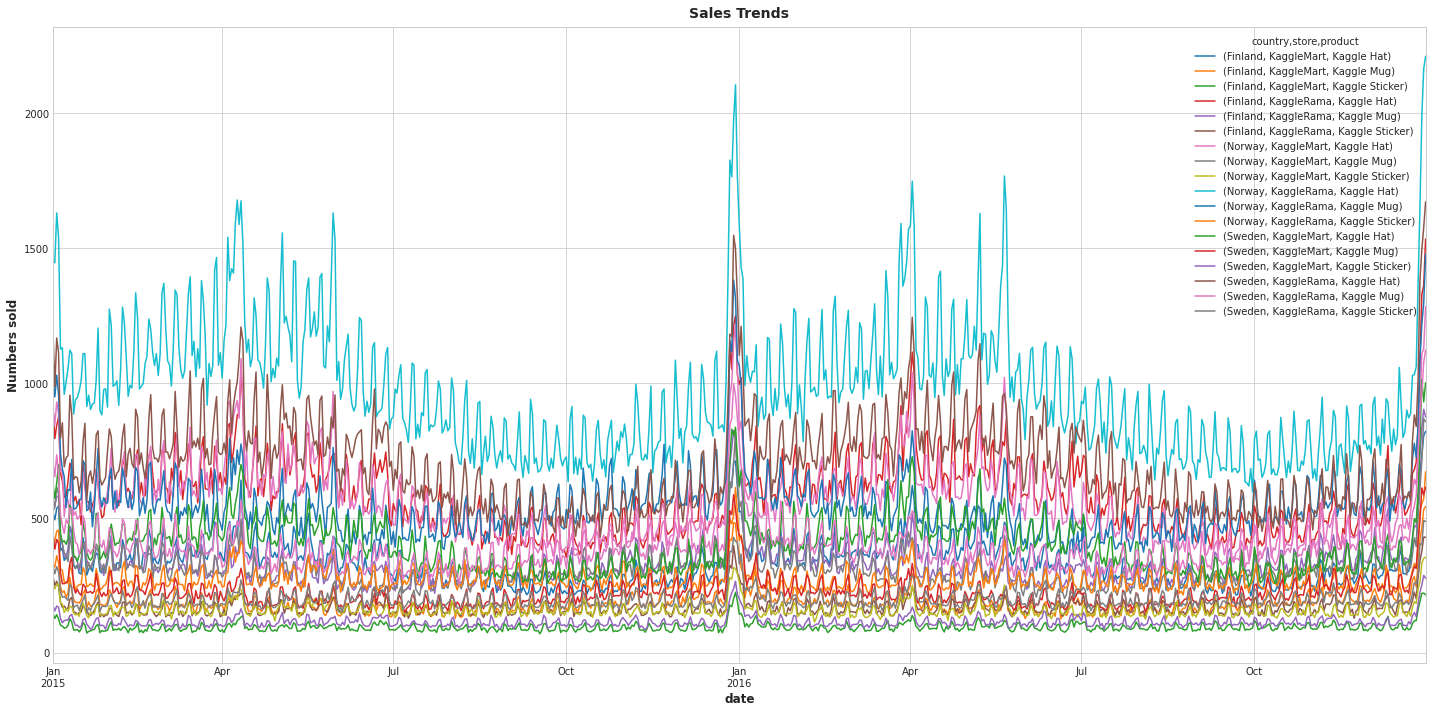

In [27]:
fig_dims = (20,10)
ax = kaggle_sales.num_sold.plot(title='Sales Trends', figsize=fig_dims)
_ = ax.set(ylabel="Numbers sold")

In [28]:
def show_me(data) :
    fig_dims = (20,10)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.set_theme(style="whitegrid")
    dates = pd.date_range("1 1 2015", periods=365, freq="D")
    dates = pd.date_range(start='1/1/2015', end='31/12/2016',  freq="D")
    data.index = dates
    sns.lineplot(data=data, palette="tab10", linewidth=1)

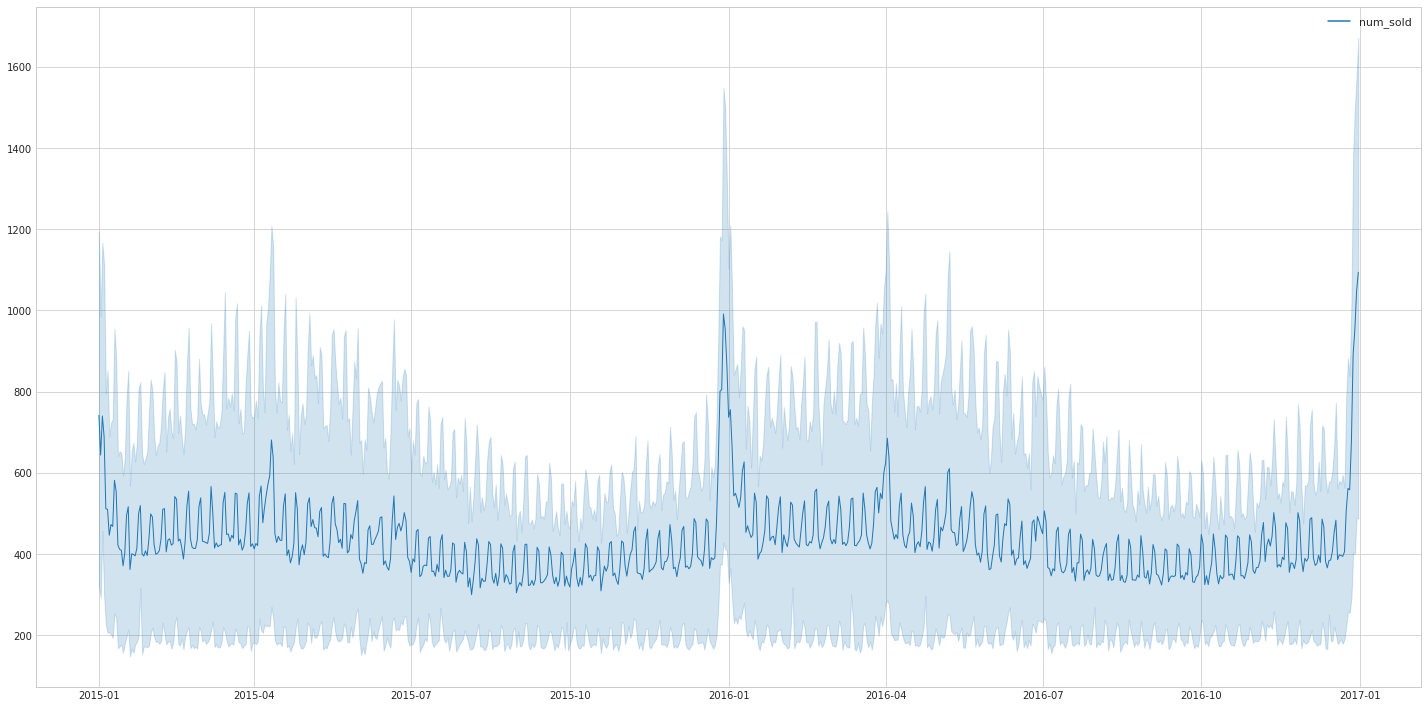

In [29]:
Rama_swe = [col for col in kaggle_sales.columns if ('KaggleRama' in col) & ('Sweden' in col)]
show_me(kaggle_sales[Rama_swe])

In [30]:
kaggle_sales[Rama_swe]

num_sold                          
country        Sweden                          
store      KaggleRama                          
product    Kaggle Hat Kaggle Mug Kaggle Sticker
date                                           
2015-01-01     1195.0      706.0          324.0
2015-01-02      986.0      653.0          293.0
2015-01-03     1167.0      734.0          319.0
2015-01-04     1112.0      657.0          300.0
2015-01-05      796.0      512.0          227.0
...               ...        ...            ...
2016-12-27     1014.0      729.0          291.0
2016-12-28     1382.0      890.0          404.0
2016-12-29     1496.0      962.0          401.0
2016-12-30     1577.0     1076.0          490.0
2016-12-31     1672.0     1123.0          487.0

[731 rows x 3 columns]

# Components and Residuals #

So that we can design effective hybrids, we need a better understanding of how time series are constructed. We've studied up to now three patterns of dependence: trend, seasons, and cycles. Many time series can be closely described by an additive model of just these three components plus some essentially unpredictable, entirely random *error*:

```
series = trend + seasons + cycles + error
```

Each of the terms in this model we would then call a **component** of the time series.

The **residuals** of a model are the difference between the target the model was trained on and the predictions the model makes -- the difference between the actual curve and the fitted curve, in other words. Plot the residuals against a feature, and you get the "left over" part of the target, or what the model failed to learn about the target from that feature.

In [31]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.unstack() # wide to long
        display(y_resid)

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid
    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.unstack()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()


In [32]:
GROUP_INDEX = ['country', 'store', 'product']

# Target series
y = kaggle_sales.loc[:, column_y]

# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = X.loc["2015-01-01":"2016-12-31"].drop(column_y, axis=1)

# Label encoding for 'family'
# le = LabelEncoder()  # from sklearn.preprocessing
# X_2 = X_2.reset_index('date')
# X_2['date'] = le.fit_transform(X_2['date'])

# Label encoding for seasonality
X_2["day"] = X_2.index.dayofyear  # values are day of the month



In [33]:
X_1

,trend
date,
2015-01-01,1.0
2015-01-02,2.0
2015-01-03,3.0
2015-01-04,4.0
2015-01-05,5.0
...,...
2016-12-27,727.0
2016-12-28,728.0
2016-12-29,729.0


In [34]:
X_2

,country,store,product,day
date,,,,
2015-01-01,0,0,1,1
2015-01-01,0,0,0,1
2015-01-01,0,0,2,1
2015-01-01,0,1,1,1
2015-01-01,0,1,0,1
...,...,...,...,...
2016-12-31,2,0,0,366
2016-12-31,2,0,2,366
2016-12-31,2,1,1,366


In [35]:
# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

In [36]:
y_train, y_valid = y[:"2015-12-31"], y["2016-01-01":]
X1_train, X1_valid = X_1[: "2015-12-31"], X_1["2016-01-01" :]
X2_train, X2_valid = X_2.loc[:"2015-12-31"], X_2.loc["2016-01-01":]

In [37]:
y_train

country       Finland                                                  \
store      KaggleMart                           KaggleRama              
product    Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug   
date                                                                    
2015-01-01      520.0      329.0          146.0      911.0      572.0   
2015-01-02      493.0      318.0          127.0      794.0      544.0   
2015-01-03      535.0      360.0          141.0      843.0      579.0   
2015-01-04      544.0      332.0          125.0      873.0      582.0   
2015-01-05      378.0      243.0          102.0      668.0      423.0   
...               ...        ...            ...        ...        ...   
2015-12-27      614.0      422.0          176.0     1152.0      699.0   
2015-12-28      620.0      417.0          171.0     1051.0      759.0   
2015-12-29      707.0      482.0          200.0     1214.0      824.0   
2015-12-30      711.0      480.0          224.0     1249.0      790.0   
2015-12-31      619.0      403.0          191.0     1031.0      665.0   

country                       Norway                                       \
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat   
date                                                                        
2015-01-01          283.0      906.0      526.0          250.0     1461.0   
2015-01-02          249.0      845.0      538.0          237.0     1446.0   
2015-01-03          265.0      930.0      614.0          254.0     1631.0   
2015-01-04          245.0      889.0      589.0          255.0     1540.0   
2015-01-05          187.0      671.0      435.0          184.0     1126.0   
...                   ...        ...        ...            ...        ...   
2015-12-27          324.0      954.0      635.0          279.0     1827.0   
2015-12-28          313.0      999.0      612.0          273.0     1765.0   
2015-12-29          397.0     1151.0      704.0          316.0     1975.0   
2015-12-30          346.0     1220.0      817.0          310.0     2106.0   
2015-12-31          296.0     1061.0      633.0          293.0     1765.0   

country                                  Sweden                            \
store                                KaggleMart                             
product    Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker   
date                                                                        
2015-01-01     1005.0          395.0      624.0      440.0          175.0   
2015-01-02      949.0          415.0      572.0      384.0          155.0   
2015-01-03     1029.0          451.0      630.0      420.0          173.0   
2015-01-04      957.0          455.0      697.0      406.0          169.0   
2015-01-05      739.0          310.0      442.0      298.0          127.0   
...               ...            ...        ...        ...            ...   
2015-12-27     1157.0          495.0      714.0      527.0          200.0   
2015-12-28     1116.0          478.0      829.0      512.0          222.0   
2015-12-29     1382.0          510.0      805.0      586.0          238.0   
2015-12-30     1315.0          613.0      836.0      534.0          265.0   
2015-12-31     1084.0          524.0      723.0      465.0          215.0   

country                                          
store      KaggleRama                            
product    Kaggle Hat Kaggle Mug Kaggle Sticker  
date                                             
2015-01-01     1195.0      706.0          324.0  
2015-01-02      986.0      653.0          293.0  
2015-01-03     1167.0      734.0          319.0  
2015-01-04     1112.0      657.0          300.0  
2015-01-05      796.0      512.0          227.0  
...               ...        ...            ...  
2015-12-27     1182.0      844.0          376.0  
2015-12-28     1173.0      869.0          

In [38]:
X1_train

,trend
date,
2015-01-01,1.0
2015-01-02,2.0
2015-01-03,3.0
2015-01-04,4.0
2015-01-05,5.0
...,...
2015-12-27,361.0
2015-12-28,362.0
2015-12-29,363.0


In [39]:
X2_train

,country,store,product,day
date,,,,
2015-01-01,0,0,1,1
2015-01-01,0,0,0,1
2015-01-01,0,0,2,1
2015-01-01,0,1,1,1
2015-01-01,0,1,0,1
...,...,...,...,...
2015-12-31,2,0,0,365
2015-12-31,2,0,2,365
2015-12-31,2,1,1,365


In [40]:
# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

country  store       product         date      
Finland  KaggleMart  Kaggle Hat      2015-01-01    126.828177
                                     2015-01-02    100.181055
                                     2015-01-03    142.533934
                                     2015-01-04    151.886812
                                     2015-01-05    -13.760310
                                                      ...    
Sweden   KaggleRama  Kaggle Sticker  2015-12-27    176.878710
                                     2015-12-28    174.865792
                                     2015-12-29    228.852874
                                     2015-12-30    213.839956
                                     2015-12-31    210.827039
Length: 6570, dtype: float64

In [41]:
y_pred

date                               2016-01-01  2016-01-02  2016-01-03  \
country store      product                                              
Finland KaggleMart Kaggle Hat      358.846274  284.034333  294.563757   
                   Kaggle Mug      301.089763  341.340948  365.822021   
                   Kaggle Sticker  161.199273  169.163965  164.763341   
        KaggleRama Kaggle Hat      471.470785  480.785943  466.748690   
                   Kaggle Mug      387.855687  517.183447  462.773083   
                   Kaggle Sticker  260.872501  222.017014  203.619163   
Norway  KaggleMart Kaggle Hat      343.160339  358.680189  329.827751   
                   Kaggle Mug      400.589087  391.312505  407.435922   
                   Kaggle Sticker  187.936774  176.537732  164.138690   
        KaggleRama Kaggle Hat      625.307384  668.774180  615.355124   
                   Kaggle Mug      629.708636  662.539942  734.171247   
                   Kaggle Sticker  285.781150  315.178226  396.175301   
Sweden  KaggleMart Kaggle Hat      249.327756  293.210946  284.039767   
                   Kaggle Mug      311.282367  342.770529  344.858690   
                   Kaggle Sticker  169.450869  184.051889  177.852909   
        KaggleRama Kaggle Hat      438.367016  429.016533  475.870139   
                   Kaggle Mug      465.195798  470.185487  446.390642   
                   Kaggle Sticker  175.295402  184.059232  198.861816   

date                               2016-01-04  2016-01-05  2016-01-06  \
country store      product                                              
Finland KaggleMart Kaggle Hat      329.022819  313.610879  304.740303   
                   Kaggle Mug      337.534587  321.199913  273.378992   
                   Kaggle Sticker  156.277137  122.887510  103.180650   
        KaggleRama Kaggle Hat      401.063848  392.921773  404.284520   
                   Kaggle Mug      414.515925  421.452423  430.331837   
                   Kaggle Sticker  197.225559  196.436200  188.038350   
Norway  KaggleMart Kaggle Hat      347.630741  397.550590  353.298153   
                   Kaggle Mug      367.358661  389.684113  413.807869   
                   Kaggle Sticker  158.537791  191.141535  220.742493   
        KaggleRama Kaggle Hat      589.793042  647.059839  551.440782   
                   Kaggle Mug      800.014801  764.652231  807.683536   
                   Kaggle Sticker  375.375577  435.374252  278.220726   
Sweden  KaggleMart Kaggle Hat      321.359851  332.643041  331.471862   
                   Kaggle Mug      368.350223  321.040070  273.216139   
                   Kaggle Sticker  161.856634  123.812105  123.213458   
        KaggleRama Kaggle Hat      415.488651  437.538169  459.391775   
                   Kaggle Mug      416.826729  406.416418  398.221574   
                   Kaggle Sticker  182.110904  172.474734  181.877317   

date                               2016-01-07  2016-01-08  2016-01-09  \
country store      product                                              
Finland KaggleMart Kaggle Hat      274.599365  263.540517  239.269941   
                   Kaggle Mug      260.952749  242.279266  245.084515   
                   Kaggle Sticker  109.444640  101.637079  102.236455   
        KaggleRama Kaggle Hat      422.552089  439.857603  415.620350   
                   Kaggle Mug      396.455650  399.585806  444.915962   
                   Kaggle Sticker  169.564070  201.353481  235.555631   
Norway  KaggleMart Kaggle Hat      340.473429  395.420992  384.368555   
                   Kaggle Mug      432.131626  449.455043  483.578460   
                   Kaggle Sticker  161.148671  148.544339  147.744648   
        KaggleRama Kaggle Hat      624.907384  631.916815  650.377238   
                   Kaggle Mug      914.459723  823.691029  660.011457   
                   Kaggle Sticker  372.939604  296.047926  290.849525   
Sweden  KaggleMart Kaggle Hat      257.966059  258.08127

In [42]:
y_fit.unstack().unstack().unstack().unstack().unstack().unstack()

country        Finland                                                     \
store       KaggleMart                             KaggleRama               
product     Kaggle Hat  Kaggle Mug Kaggle Sticker  Kaggle Hat  Kaggle Mug   
date                                                                        
2015-01-01  487.646908  394.525140     232.610688  786.812181  581.522175   
2015-01-02  412.834968  291.537015     245.607127  787.500422  470.016596   
2015-01-03  423.364392  331.788199     157.002437  762.831077  541.125327   
2015-01-04  457.823454  356.269272     164.967128  684.092032  498.514964   
2015-01-05  442.411514  327.981838     160.566504  693.407190  376.407063   
...                ...         ...            ...         ...         ...   
2015-12-27  611.469090  246.360001     139.024096  759.463242  531.416327   
2015-12-28  513.417788  404.352196     152.146191  745.110832  641.005738   
2015-12-29  486.093569  310.816929     203.095064  834.700764  578.252234   
2015-12-30  536.716168  300.228051     170.394060  862.137878  605.260673   
2015-12-31  514.339387  302.653046     171.987812  832.629941  486.515784   

country                        Norway                                          \
store                      KaggleMart                              KaggleRama   
product    Kaggle Sticker  Kaggle Hat  Kaggle Mug Kaggle Sticker   Kaggle Hat   
date                                                                            
2015-01-01     308.712449  828.796136  720.659816     314.943812  1337.979852   
2015-01-02     326.512502  786.215357  494.256718     339.745419  1254.417038   
2015-01-03     347.121046  804.434578  446.781153     265.762280  1296.158939   
2015-01-04     323.067709  809.729704  453.104570     275.963887  1260.183359   
2015-01-05     287.433793  785.500734  422.825952     288.565493  1235.525570   
...                   ...         ...         ...            ...          ...   
2015-12-27     251.693413  804.193993  390.190164     244.506838  1203.104520   
2015-12-28     243.497659  784.869897  620.995930     282.926514  1291.676679   
2015-12-29     270.110397  741.381154  497.425909     243.006499  1239.813384   
2015-12-30     285.318890  776.532963  519.024272     275.308695  1396.288927   
2015-12-31     225.669903  892.525323  494.624492     310.328370  1427.819508   

country                                     Sweden                             \
store                                   KaggleMart                              
product      Kaggle Mug Kaggle Sticker  Kaggle Hat  Kaggle Mug Kaggle Sticker   
date                                                                            
2015-01-01  1119.618780     431.646880  566.253279  521.389479     271.434813   
2015-01-02  1189.281391     407.848480  552.395711  411.357133     287.933900   
2015-01-03  1123.175308     455.278879  556.538142  399.531769     136.468465   
2015-01-04  1045.746098     375.168001  582.310995  395.906406     143.665427   
2015-01-05   665.526509     344.169601  590.568637  377.884415     139.066446   
...                 ...            ...         ...         ...            ...   
2015-12-27   857.740858     403.807341  595.019422  284.248892     134.237879   
2015-12-28   833.553107     398.981720  584.334632  418.035405      98.447484   
2015-12-29   901.571480     505.969313  545.537750  367.990189     263.404730   
2015-12-30   987.977604     434.935277  594.995475  359.192208     198.929255   
2015-12-31   755.426885     410.578891  646.425896  361.396933     235.826102   

country                                             
store        KaggleRama                             
product      Kaggle Hat  Kaggle Mug Kaggle Sticker  
date                                                
2015-01-01  1023.090600  771.976121     392.167430  
2015-01-02   937.887894  823.494685     405.564870  
2015-01-03   964.646006  778.759644     434.367477  
2015-01-04   902.408176  753.820169     3

In [43]:
y

country       Finland                                                  \
store      KaggleMart                           KaggleRama              
product    Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug   
date                                                                    
2015-01-01      520.0      329.0          146.0      911.0      572.0   
2015-01-02      493.0      318.0          127.0      794.0      544.0   
2015-01-03      535.0      360.0          141.0      843.0      579.0   
2015-01-04      544.0      332.0          125.0      873.0      582.0   
2015-01-05      378.0      243.0          102.0      668.0      423.0   
...               ...        ...            ...        ...        ...   
2016-12-27      513.0      336.0          160.0      838.0      566.0   
2016-12-28      671.0      419.0          190.0     1077.0      729.0   
2016-12-29      732.0      463.0          220.0     1328.0      833.0   
2016-12-30      805.0      531.0          221.0     1362.0      903.0   
2016-12-31      821.0      542.0          215.0     1534.0      874.0   

country                       Norway                                       \
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat   
date                                                                        
2015-01-01          283.0      906.0      526.0          250.0     1461.0   
2015-01-02          249.0      845.0      538.0          237.0     1446.0   
2015-01-03          265.0      930.0      614.0          254.0     1631.0   
2015-01-04          245.0      889.0      589.0          255.0     1540.0   
2015-01-05          187.0      671.0      435.0          184.0     1126.0   
...                   ...        ...        ...            ...        ...   
2016-12-27          279.0      742.0      518.0          235.0     1367.0   
2016-12-28          341.0      912.0      606.0          262.0     1652.0   
2016-12-29          377.0     1109.0      714.0          332.0     1992.0   
2016-12-30          429.0     1128.0      868.0          350.0     2166.0   
2016-12-31          428.0     1284.0      857.0          354.0     2212.0   

country                                  Sweden                            \
store                                KaggleMart                             
product    Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker   
date                                                                        
2015-01-01     1005.0          395.0      624.0      440.0          175.0   
2015-01-02      949.0          415.0      572.0      384.0          155.0   
2015-01-03     1029.0          451.0      630.0      420.0          173.0   
2015-01-04      957.0          455.0      697.0      406.0          169.0   
2015-01-05      739.0          310.0      442.0      298.0          127.0   
...               ...            ...        ...        ...            ...   
2016-12-27      840.0          405.0      595.0      412.0          181.0   
2016-12-28     1087.0          525.0      786.0      492.0          224.0   
2016-12-29     1219.0          553.0     1013.0      611.0          251.0   
2016-12-30     1298.0          570.0      930.0      585.0          287.0   
2016-12-31     1476.0          671.0     1001.0      614.0          276.0   

country                                          
store      KaggleRama                            
product    Kaggle Hat Kaggle Mug Kaggle Sticker  
date                                             
2015-01-01     1195.0      706.0          324.0  
2015-01-02      986.0      653.0          293.0  
2015-01-03     1167.0      734.0          319.0  
2015-01-04     1112.0      657.0          300.0  
2015-01-05      796.0      512.0          227.0  
...               ...        ...            ...  
2016-12-27     1014.0      729.0          291.0  
2016-12-28     1382.0      890.0          

In [44]:
families = y.columns[0:]

In [45]:
y_fit.unstack().unstack().unstack().unstack().unstack().unstack().loc(axis=1)[families]

country        Finland                                                     \
store       KaggleMart                             KaggleRama               
product     Kaggle Hat  Kaggle Mug Kaggle Sticker  Kaggle Hat  Kaggle Mug   
date                                                                        
2015-01-01  487.646908  394.525140     232.610688  786.812181  581.522175   
2015-01-02  412.834968  291.537015     245.607127  787.500422  470.016596   
2015-01-03  423.364392  331.788199     157.002437  762.831077  541.125327   
2015-01-04  457.823454  356.269272     164.967128  684.092032  498.514964   
2015-01-05  442.411514  327.981838     160.566504  693.407190  376.407063   
...                ...         ...            ...         ...         ...   
2015-12-27  611.469090  246.360001     139.024096  759.463242  531.416327   
2015-12-28  513.417788  404.352196     152.146191  745.110832  641.005738   
2015-12-29  486.093569  310.816929     203.095064  834.700764  578.252234   
2015-12-30  536.716168  300.228051     170.394060  862.137878  605.260673   
2015-12-31  514.339387  302.653046     171.987812  832.629941  486.515784   

country                        Norway                                          \
store                      KaggleMart                              KaggleRama   
product    Kaggle Sticker  Kaggle Hat  Kaggle Mug Kaggle Sticker   Kaggle Hat   
date                                                                            
2015-01-01     308.712449  828.796136  720.659816     314.943812  1337.979852   
2015-01-02     326.512502  786.215357  494.256718     339.745419  1254.417038   
2015-01-03     347.121046  804.434578  446.781153     265.762280  1296.158939   
2015-01-04     323.067709  809.729704  453.104570     275.963887  1260.183359   
2015-01-05     287.433793  785.500734  422.825952     288.565493  1235.525570   
...                   ...         ...         ...            ...          ...   
2015-12-27     251.693413  804.193993  390.190164     244.506838  1203.104520   
2015-12-28     243.497659  784.869897  620.995930     282.926514  1291.676679   
2015-12-29     270.110397  741.381154  497.425909     243.006499  1239.813384   
2015-12-30     285.318890  776.532963  519.024272     275.308695  1396.288927   
2015-12-31     225.669903  892.525323  494.624492     310.328370  1427.819508   

country                                     Sweden                             \
store                                   KaggleMart                              
product      Kaggle Mug Kaggle Sticker  Kaggle Hat  Kaggle Mug Kaggle Sticker   
date                                                                            
2015-01-01  1119.618780     431.646880  566.253279  521.389479     271.434813   
2015-01-02  1189.281391     407.848480  552.395711  411.357133     287.933900   
2015-01-03  1123.175308     455.278879  556.538142  399.531769     136.468465   
2015-01-04  1045.746098     375.168001  582.310995  395.906406     143.665427   
2015-01-05   665.526509     344.169601  590.568637  377.884415     139.066446   
...                 ...            ...         ...         ...            ...   
2015-12-27   857.740858     403.807341  595.019422  284.248892     134.237879   
2015-12-28   833.553107     398.981720  584.334632  418.035405      98.447484   
2015-12-29   901.571480     505.969313  545.537750  367.990189     263.404730   
2015-12-30   987.977604     434.935277  594.995475  359.192208     198.929255   
2015-12-31   755.426885     410.578891  646.425896  361.396933     235.826102   

country                                             
store        KaggleRama                             
product      Kaggle Hat  Kaggle Mug Kaggle Sticker  
date                                                
2015-01-01  1023.090600  771.976121     392.167430  
2015-01-02   937.887894  823.494685     405.564870  
2015-01-03   964.646006  778.759644     434.367477  
2015-01-04   902.408176  753.820169     3

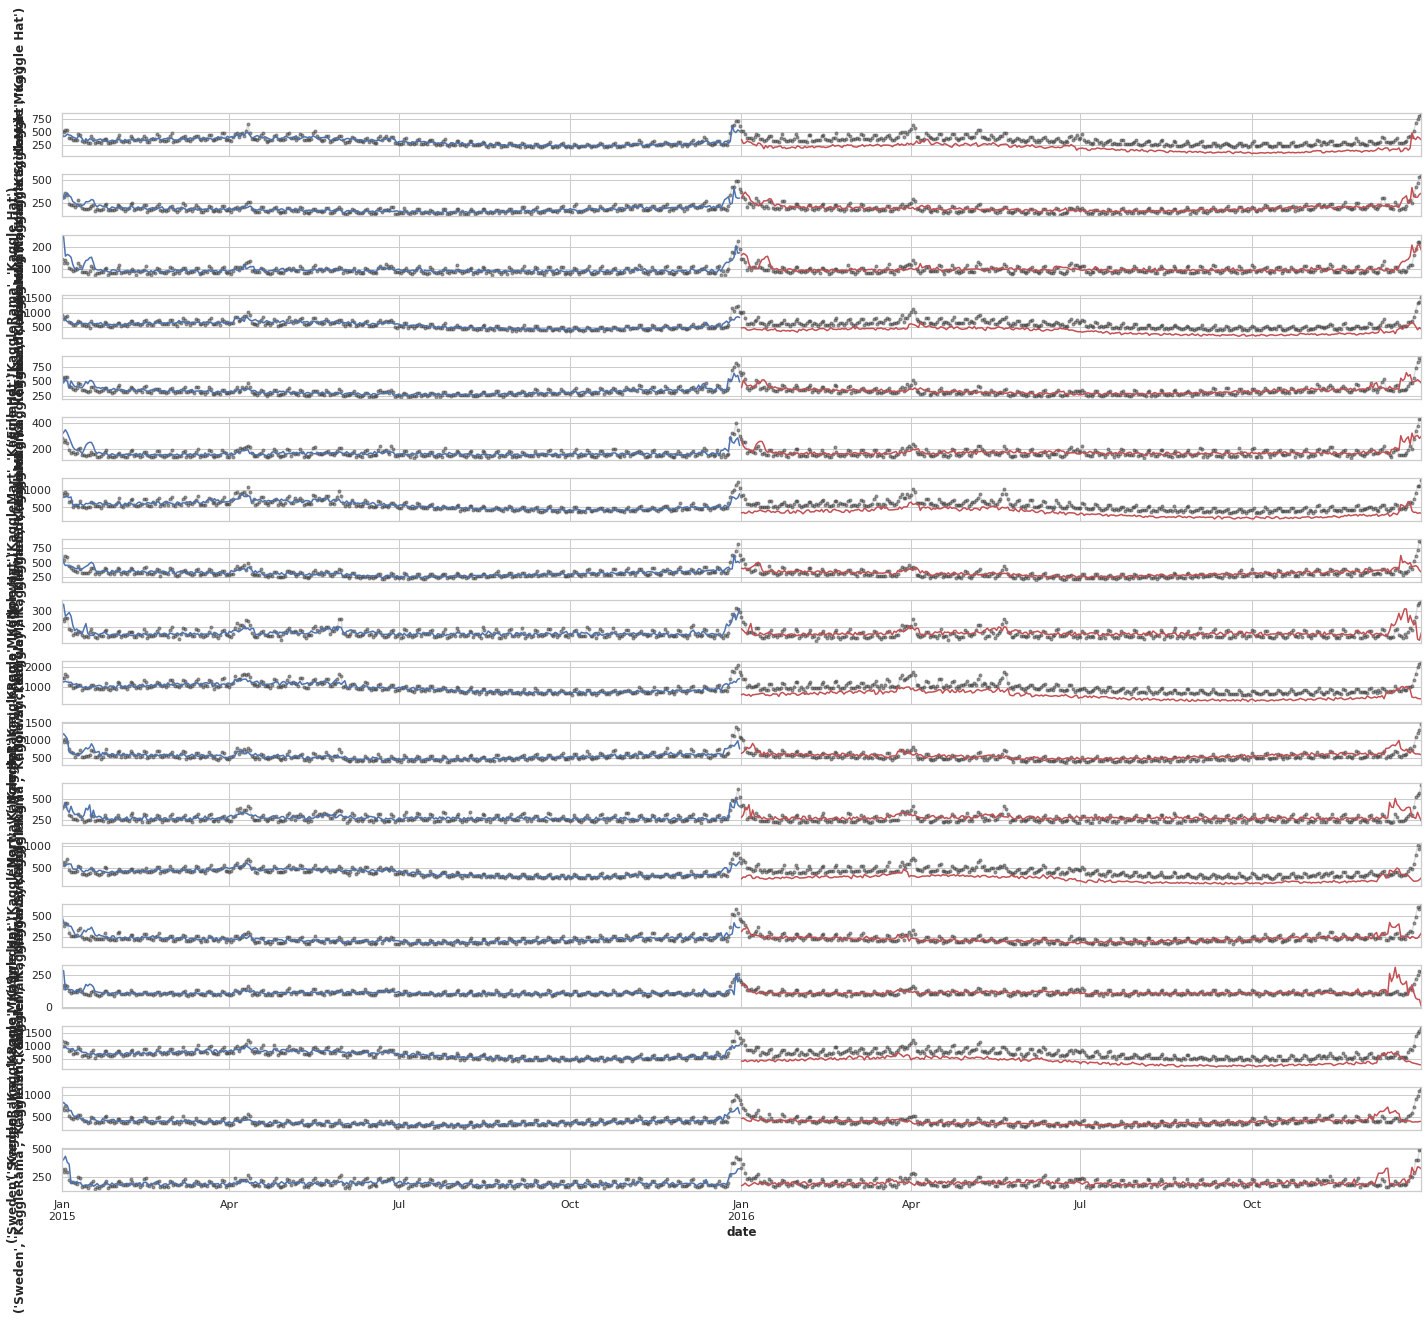

In [46]:
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(20, 16), **plot_params, alpha=0.5,
)
_ = y_fit.unstack().unstack().unstack().unstack().unstack().unstack().loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.unstack().unstack().unstack().unstack().unstack().unstack().loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

In [47]:
y_train

country       Finland                                                  \
store      KaggleMart                           KaggleRama              
product    Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug   
date                                                                    
2015-01-01      520.0      329.0          146.0      911.0      572.0   
2015-01-02      493.0      318.0          127.0      794.0      544.0   
2015-01-03      535.0      360.0          141.0      843.0      579.0   
2015-01-04      544.0      332.0          125.0      873.0      582.0   
2015-01-05      378.0      243.0          102.0      668.0      423.0   
...               ...        ...            ...        ...        ...   
2015-12-27      614.0      422.0          176.0     1152.0      699.0   
2015-12-28      620.0      417.0          171.0     1051.0      759.0   
2015-12-29      707.0      482.0          200.0     1214.0      824.0   
2015-12-30      711.0      480.0          224.0     1249.0      790.0   
2015-12-31      619.0      403.0          191.0     1031.0      665.0   

country                       Norway                                       \
store                     KaggleMart                           KaggleRama   
product    Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker Kaggle Hat   
date                                                                        
2015-01-01          283.0      906.0      526.0          250.0     1461.0   
2015-01-02          249.0      845.0      538.0          237.0     1446.0   
2015-01-03          265.0      930.0      614.0          254.0     1631.0   
2015-01-04          245.0      889.0      589.0          255.0     1540.0   
2015-01-05          187.0      671.0      435.0          184.0     1126.0   
...                   ...        ...        ...            ...        ...   
2015-12-27          324.0      954.0      635.0          279.0     1827.0   
2015-12-28          313.0      999.0      612.0          273.0     1765.0   
2015-12-29          397.0     1151.0      704.0          316.0     1975.0   
2015-12-30          346.0     1220.0      817.0          310.0     2106.0   
2015-12-31          296.0     1061.0      633.0          293.0     1765.0   

country                                  Sweden                            \
store                                KaggleMart                             
product    Kaggle Mug Kaggle Sticker Kaggle Hat Kaggle Mug Kaggle Sticker   
date                                                                        
2015-01-01     1005.0          395.0      624.0      440.0          175.0   
2015-01-02      949.0          415.0      572.0      384.0          155.0   
2015-01-03     1029.0          451.0      630.0      420.0          173.0   
2015-01-04      957.0          455.0      697.0      406.0          169.0   
2015-01-05      739.0          310.0      442.0      298.0          127.0   
...               ...            ...        ...        ...            ...   
2015-12-27     1157.0          495.0      714.0      527.0          200.0   
2015-12-28     1116.0          478.0      829.0      512.0          222.0   
2015-12-29     1382.0          510.0      805.0      586.0          238.0   
2015-12-30     1315.0          613.0      836.0      534.0          265.0   
2015-12-31     1084.0          524.0      723.0      465.0          215.0   

country                                          
store      KaggleRama                            
product    Kaggle Hat Kaggle Mug Kaggle Sticker  
date                                             
2015-01-01     1195.0      706.0          324.0  
2015-01-02      986.0      653.0          293.0  
2015-01-03     1167.0      734.0          319.0  
2015-01-04     1112.0      657.0          300.0  
2015-01-05      796.0      512.0          227.0  
...               ...        ...            ...  
2015-12-27     1182.0      844.0          376.0  
2015-12-28     1173.0      869.0          

In [48]:
pred_test_df_by_year = pd.DataFrame(y_fit,columns=y_fit.columns.tolist())

In [49]:
sub = pd.read_csv('../input/tabular-playground-series-jan-2022/sample_submission.csv')

In [50]:
pred_test_df_by_year

2015-01-01   2015-01-02   2015-01-03  \
country store      product                                                 
Finland KaggleMart Kaggle Hat       487.646908   412.834968   423.364392   
                   Kaggle Mug       394.525140   291.537015   331.788199   
                   Kaggle Sticker   232.610688   245.607127   157.002437   
        KaggleRama Kaggle Hat       786.812181   787.500422   762.831077   
                   Kaggle Mug       581.522175   470.016596   541.125327   
                   Kaggle Sticker   308.712449   326.512502   347.121046   
Norway  KaggleMart Kaggle Hat       828.796136   786.215357   804.434578   
                   Kaggle Mug       720.659816   494.256718   446.781153   
                   Kaggle Sticker   314.943812   339.745419   265.762280   
        KaggleRama Kaggle Hat      1337.979852  1254.417038  1296.158939   
                   Kaggle Mug      1119.618780  1189.281391  1123.175308   
                   Kaggle Sticker   431.646880   407.848480   455.278879   
Sweden  KaggleMart Kaggle Hat       566.253279   552.395711   556.538142   
                   Kaggle Mug       521.389479   411.357133   399.531769   
                   Kaggle Sticker   271.434813   287.933900   136.468465   
        KaggleRama Kaggle Hat      1023.090600   937.887894   964.646006   
                   Kaggle Mug       771.976121   823.494685   778.759644   
                   Kaggle Sticker   392.167430   405.564870   434.367477   

                                    2015-01-04   2015-01-05   2015-01-06  \
country store      product                                                 
Finland KaggleMart Kaggle Hat       457.823454   442.411514   433.540938   
                   Kaggle Mug       356.269272   327.981838   311.647165   
                   Kaggle Sticker   164.967128   160.566504   152.080301   
        KaggleRama Kaggle Hat       684.092032   693.407190   679.369937   
                   Kaggle Mug       498.514964   376.407063   505.734823   
                   Kaggle Sticker   323.067709   287.433793   253.229600   
Norway  KaggleMart Kaggle Hat       809.729704   785.500734   801.519955   
                   Kaggle Mug       453.104570   422.825952   437.150387   
                   Kaggle Sticker   275.963887   288.565493   266.167719   
        KaggleRama Kaggle Hat      1260.183359  1235.525570  1249.467780   
                   Kaggle Mug      1045.746098   665.526509   641.640769   
                   Kaggle Sticker   375.168001   344.169601   416.264849   
Sweden  KaggleMart Kaggle Hat       582.310995   590.568637   586.711069   
                   Kaggle Mug       395.906406   377.884415   376.260737   
                   Kaggle Sticker   143.665427   139.066446   138.075583   
        KaggleRama Kaggle Hat       902.408176   884.166288   889.524400   
                   Kaggle Mug       753.820169   639.282026   642.390280   
                   Kaggle Sticker   381.149496   365.346936   195.568997   

                                    2015-01-07   2015-01-08   2015-01-09  \
country store      product                                                 
Finland KaggleMart Kaggle Hat       403.400000   392.341151   368.070576   
                   Kaggle Mug       263.826244   251.400000   232.726517   
                   Kaggle Sticker   118.690673    98.983814   105.247804   
        KaggleRama Kaggle Hat       613.685095   605.543020   616.905767   
                   Kaggle Mug       451.324459   403.067300   410.003799   
                   Kaggle Sticker   214.374113   195.976262   189.582658   
Norway  KaggleMart Kaggle Hat       565.911925   581.431774   552.579337   
                   Kaggle Mug       425.073804   401.196204   391.919621   
                   Kaggle Sticker   208.383092   176.583741   187.384389   
        KaggleRama Kaggle Hat      1146.206852  1137.596917  1182.558493   
                   Kaggle Mug       657.046893   605.763254   585.677514   
      

In [51]:
def make_submission(df):
    submission = pd.DataFrame(data=np.zeros((sub.shape[0],2)),index = sub.index.tolist(),columns=['row_id','num_sold'])
    INDEX = -1
    for i in range(365):
        for j in range (18) :
            INDEX +=1
            submission['num_sold'].loc[INDEX,1]=df.iloc[j,i]
    submission['row_id'] = sub['row_id']
    return submission

submission_by_year = make_submission(pred_test_df_by_year)
display(submission_by_year.head(3))

,row_id,num_sold
0,26298,487.646908
1,26299,325.074923
2,26300,232.610688


In [52]:
submission_by_year.to_csv('submission.csv',index=False)